###Team Members: Emeline Fratacci, Akshaya Brian Tauro,
###Course Number : CS 512, Semester : Spring 2023

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Datasets

In [ ]:
input_oral_cancer_path = "/content/drive/MyDrive/cs577_DL_Project/project/data/oral cancer/cancers"
target_oral_cancer_path = "/content/drive/MyDrive/cs577_DL_Project/project/data/oral cancer/masks"

###Prepare the data

In [ ]:
import os
#get image paths and sort by name
input_oral_cancer_paths = sorted(
    [os.path.join(input_oral_cancer_path, fname)
    for fname in os.listdir(input_oral_cancer_path)
        if fname.endswith(".jpg")]
        )
print("Total - Oral Cancer Input Samples", len(input_oral_cancer_paths))


target_oral_cancer_paths = sorted(
    [os.path.join(target_oral_cancer_path, fname)
    for fname in os.listdir(target_oral_cancer_path)
    if fname.endswith(".jpg") and not fname.startswith(".") ])
print("Total - Oral Cancer Target Samples", len(target_oral_cancer_paths))

Total - Oral Cancer Input Samples 86
Total - Oral Cancer Target Samples 86


**Visualize the oral cancer segmentation mask**

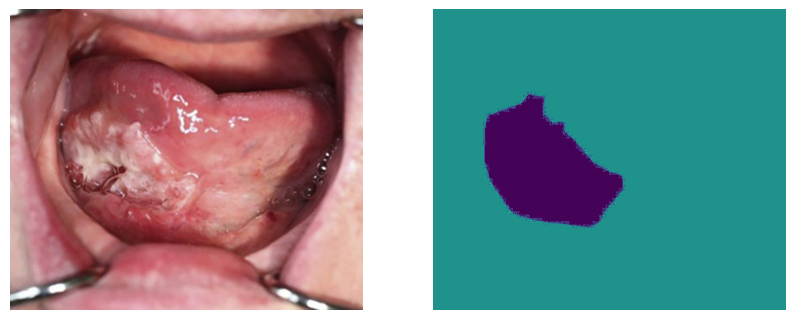

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

def display_target(target_array):
    normalized_array = (target_array.astype("uint8")-1)*127
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(load_img(input_oral_cancer_paths[35]))
    axs[0].axis('off')
    axs[1].imshow(normalized_array[:,:,0])
    axs[1].axis('off')
    plt.show()

img = img_to_array(load_img(target_oral_cancer_paths[35], color_mode = 'grayscale'))

display_target(img)

In [ ]:
import numpy as np
import random
img_size = (200,200) #resize images to 200 * 200
num_imgs = len(input_oral_cancer_paths) # total number of images

#use the same random seed to make sure images and segmentation maps match
random.Random(1337).shuffle(input_oral_cancer_paths)
random.Random(1337).shuffle(target_oral_cancer_paths)

#load image function
def path_to_input_image(path):
  return img_to_array(load_img(path, target_size = img_size))


#load segmentation map function
def path_to_target(path):
  img = img_to_array(load_img(path, target_size = img_size, color_mode = "grayscale"))
  return img

#load all images
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype = "float32") # RGB
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8") # gray


for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_oral_cancer_paths[i])
    targets[i] = path_to_target(target_oral_cancer_paths[i])

In [ ]:
import random
from tensorflow.keras.preprocessing.image import array_to_img
from keras.models import load_model

Note: The trained model has MeanIOU which has to be updated. Hence, running the class Mean_IoU before loading the model

In [ ]:
import tensorflow as tf

# Bug fix code for MeanIOU keras
# From https://stackoverflow.com/questions/61824470/dimensions-mismatch-error-when-using-tf-metrics-meaniou-with-sparsecategorical

class Mean_IoU(tf.keras.metrics.MeanIoU):
  def __init__(self,
               num_classes=None,
               name=None,
               dtype=None,
               **kwargs):
    super(Mean_IoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype,
        **kwargs)

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    return super().update_state(y_true, y_pred, sample_weight)

**Test - Model of Exp 1**

1/1 [==============================] - 1s 1s/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.92     67556
           1       0.00      0.00      0.00       485
           2       0.00      0.00      0.00       269
           3       0.00      0.00      0.00       113
           4       0.00      0.00      0.00        46
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
         248       0.00      0.00      0.00         4
         250       0.00      0.00      0.00        20
         251       0.00      0.00      0.00        41
         252       0.00      0.00      0.00       121
         253       0.00      0.00      0.00       236
         254       0.00      0.00      0.00       428
         255       0.00      0.00      0.00     10654

    accuracy                           0.84     80000
   macro avg       0.06      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


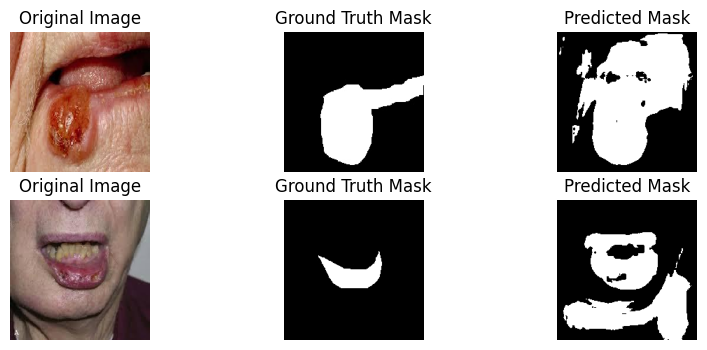

In [ ]:
from sklearn.metrics import classification_report

model_path = ("/content/drive/MyDrive/cs577_DL_Project/project/data/models/Final_Model-ISIC 2017 Dataset_Exp_1.h5")
model = load_model(model_path,  custom_objects={"Mean_IoU": Mean_IoU } )


randomly select some test images
indices = random.sample(range(len(input_imgs)), 2)

# make predictions using the trained model
predicted_masks = model.predict(input_imgs[indices])

# binary classification, extract the foreground probabilities
foreground_probabilities = predicted_masks[..., 1]

predicted_labels = (foreground_probabilities).astype(int).flatten()

# get true class labels
true_labels = targets[indices].flatten()

# print classification report
print(classification_report(true_labels, predicted_labels))

# display the original images, ground truth masks, and predicted masks
fig, axes = plt.subplots(len(indices), 3, figsize=(10, 4))

for i, index in enumerate(indices):
    # original image
    img = array_to_img(input_imgs[index])
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    # ground truth mask
    axes[i, 1].imshow(targets[index].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth Mask')

    # predicted mask
    axes[i, 2].imshow(predicted_masks[i].argmax(axis=-1), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Mask')

plt.show()

**Test - Model of Exp 2**

1/1 [==============================] - 1s 867ms/step
              precision    recall  f1-score   support

           0       0.84      1.00      0.92     67556
           1       0.00      0.00      0.00       485
           2       0.00      0.00      0.00       269
           3       0.00      0.00      0.00       113
           4       0.00      0.00      0.00        46
           5       0.00      0.00      0.00        24
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         1
         248       0.00      0.00      0.00         4
         250       0.00      0.00      0.00        20
         251       0.00      0.00      0.00        41
         252       0.00      0.00      0.00       121
         253       0.00      0.00      0.00       236
         254       0.00      0.00      0.00       428
         255       0.00      0.00      0.00     10654

    accuracy                           0.84     80000
   macro avg       0.06    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


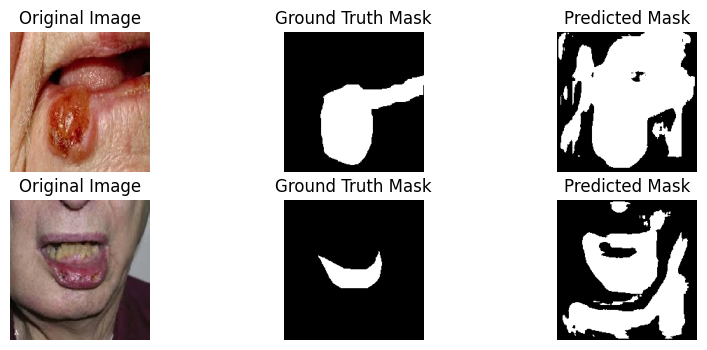

In [ ]:
from sklearn.metrics import classification_report

model_path = ("/content/drive/MyDrive/cs577_DL_Project/project/data/models/Final_Model-ISIC 2017 Dataset_Exp_2.h5")
model = load_model(model_path,  custom_objects={"Mean_IoU": Mean_IoU } )


# randomly select some test images
indices = random.sample(range(len(input_imgs)), 2)

# make predictions using the trained model
predicted_masks = model.predict(input_imgs[indices])

# binary classification, extract the foreground probabilities
foreground_probabilities = predicted_masks[..., 1]

predicted_labels = (foreground_probabilities).astype(int).flatten()

# get true class labels
true_labels = targets[indices].flatten()

# print classification report
print(classification_report(true_labels, predicted_labels))

# display the original images, ground truth masks, and predicted masks
fig, axes = plt.subplots(len(indices), 3, figsize=(10, 4))

for i, index in enumerate(indices):
    # original image
    # axes[i, 0].imshow(test_input_imgs[index])
    img = array_to_img(input_imgs[index])
    axes[i, 0].imshow(img)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')

    # ground truth mask
    axes[i, 1].imshow(targets[index].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Ground Truth Mask')

    # predicted mask
    axes[i, 2].imshow(predicted_masks[i].argmax(axis=-1), cmap='gray')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Mask')

plt.show()